# LSTM for Website 

This notebook retrains the **best-performing model** identified in this study, which, in this case is the **LSTM** (see *Pre-processing & RF & SVM* and *Pre-processing & LSTM*) and saves it to then use it in the web implementation.
The pipeline follows the same structure as the one used in the *Pre-processing & LSTM* notebook, with one key difference: the **dataset partitioning strategy**. Given that the primary objective of this implementation is to train the model to use it to compute predictive `alert_11` values, the dataset is divided into **two parts**:
- **Training and Testing (80%)**: to train and evaluate the model’s performance;
- **Prediction (20%)**: is left aside and will be used in the webpage backend to compare the predicted data with their ground values.

This modified partitioning ensures that a dedicated portion of the dataset is reserved for the real-time predictions in the webpage, enusuring that the model predicts on data that it has never seen before.

Firstly, the **`os`** library is utilised to interact with the operating system. By setting the logging level to `2`, it filters out **INFO** and **WARNING** messages, allowing only **ERROR** messages to be displayed. This adjustment improves readability by ensuring that only critical issues are shown, making error messages clearer and easier to interpret.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Data loading

In [2]:
import pandas as pd

df = pd.read_parquet('./../data/dataset.parquet', engine='pyarrow')

In [3]:
# Check the dataset has been imported correctly
df.shape

(679045, 17)

## Data partition

In [4]:
# Calculate the split point (80% of the data)
split_point = int(len(df) * 0.8)

In [5]:
# Split the DataFrame
df_80 = df[:split_point]
df_20 = df[split_point:]

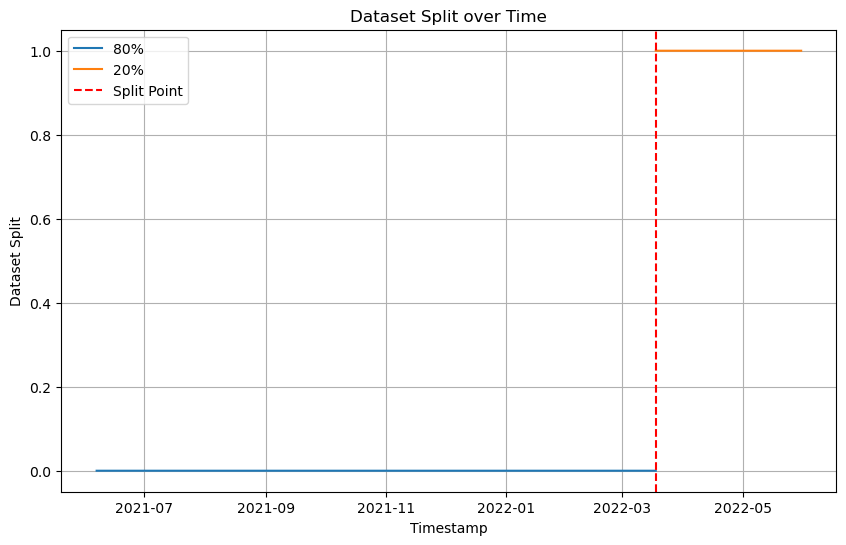

In [6]:
# Plot to visualise the partition
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_80['Timestamp'], [0] * len(df_80), label='80%')  
plt.plot(df_20['Timestamp'], [1] * len(df_20), label='20%') 
plt.axvline(x=df_20['Timestamp'].iloc[0], color='red', linestyle='--', label='Split Point')

plt.xlabel('Timestamp')
plt.ylabel('Dataset Split') 
plt.title('Dataset Split over Time')
plt.legend()
plt.grid(True)
plt.show()

Verify that each split contains `1s` in the `alert_11` feature to ensure that the model has the chance to train and predict both `alert_11` values.

In [7]:
# Count 0s and 1s in 'alert_11' for each split
def count_alerts(df, alert_column='alert_11'):
    count_0 = (df[alert_column] == 0).sum()
    count_1 = (df[alert_column] == 1).sum()
    return count_0, count_1

count_0_80, count_1_80 = count_alerts(df_80)
count_0_20, count_1_20 = count_alerts(df_20)

print("80% Dataset:")
print(f"Number of 0s in alert_11: {count_0_80}")
print(f"Number of 1s in alert_11: {count_1_80}")

print("\n20% Dataset:")
print(f"Number of 0s in alert_11: {count_0_20}")
print(f"Number of 1s in alert_11: {count_1_20}")

80% Dataset:
Number of 0s in alert_11: 541860
Number of 1s in alert_11: 1376

20% Dataset:
Number of 0s in alert_11: 135792
Number of 1s in alert_11: 17


Now that the dataset has been partitioned, **`df_80`** will be assigned as **`df`**, ensuring that all model training and testing processes are conducted on this subset. This adjustment allows for the rest of the code to be the same as the one in *Pre-processing & LSTM*.

In [8]:
# Assign the 80% split to df 
df = df_80

## Pre-processing steps

### Data optimisation

As implemented in the *Pre-processing & RF & SVM* and *Pre-processing & LSTM* notebooks, the `session_counter` and `time_to_failure` features are removed from the dataset, as they are not relevant to the classification task. Eliminating these features ensures that the model focuses solely on the meaningful variables that contribute to the prediction of `alert_11`.

In [9]:
# Removing unnecessary columns
df.drop(columns=['session_counter', 'time_to_failure'], inplace=True)

In [10]:
# Display the dataset to ensure the columns have been removed
df.head()

,Timestamp,Flag roping,Platform Position [°],Platform Motor frequency [HZ],Temperature platform drive [°C],Temperature slave drive [°C],Temperature hoist drive [°C],Tensione totale film [%],Current speed cart [%],Platform motor speed [%],Lifting motor speed [RPM],Platform rotation speed [RPM],Slave rotation speed [M/MIN],Lifting speed rotation [M/MIN],alert_11
0,2021-06-07 04:14:30.742,31.0,115.0,5200.0,18.0,22.0,18.0,181.0,0.0,100.0,0.0,84.0,116.0,0.0,0.0
1,2021-06-07 04:14:35.742,31.0,115.0,5200.0,18.0,22.0,18.0,181.0,0.0,100.0,0.0,84.0,116.0,0.0,0.0
2,2021-06-07 04:14:40.742,31.0,115.0,5200.0,18.0,22.0,18.0,181.0,0.0,100.0,0.0,84.0,116.0,0.0,0.0
3,2021-06-07 04:14:45.742,31.0,115.0,5200.0,18.0,22.0,18.0,181.0,0.0,100.0,0.0,84.0,116.0,0.0,0.0
4,2021-06-07 04:14:50.742,31.0,115.0,5200.0,18.0,22.0,18.0,181.0,0.0,100.0,0.0,84.0,116.0,0.0,0.0


As is common in most time-series datasets, the `Timestamp` column is set as the index of the dataset. This allows for efficient time-based operations, such as resampling, sliding window calculations, and trend analysis, while preserving the chronological structure of the data.

In [11]:
# Setting Timestamp as index
df.set_index('Timestamp', inplace=True)

In [12]:
# Check if Timestamp has become the index of the dataset
df.index.name

'Timestamp'

### Feature extraction

In this section, the label `y` and the features `X` for the models are defined, with `alert_11` serving as the target variable (`y`) and all other columns being designated as features (`X`). This decision is based on the fact that `alert_11` represents the primary event of interest, aligning with the original study’s objective. By including all other columns as features, the model can leverage the full range of available data to identify patterns and relationships that may contribute to predicting `alert_11`.

In [13]:
# State the label and the features
import numpy as np

label = np.array(['alert_11'])
features = np.array(df.columns.difference(label))

print(f"-> Label (shape={label.shape}): {label}")
print(f"-> Features (shape={features.shape}): {features}")

-> Label (shape=(1,)): ['alert_11']
-> Features (shape=(13,)): ['Current speed cart [%]' 'Flag roping' 'Lifting motor speed [RPM]'
 'Lifting speed rotation [M/MIN]' 'Platform Motor frequency [HZ]'
 'Platform Position [°]' 'Platform motor speed [%]'
 'Platform rotation speed [RPM]' 'Slave rotation speed [M/MIN]'
 'Temperature hoist drive [°C]' 'Temperature platform drive [°C]'
 'Temperature slave drive [°C]' 'Tensione totale film [%]']


In [14]:
# Extract and assign the label and the features, X and y
X = df[features]
y = df[label]

print(f"-> X (shape={X.shape})")
print(f"-> y (shape={y.shape})")

-> X (shape=(543236, 13))
-> y (shape=(543236, 1))


### Sliding window

Creating sliding windows as a pre-processing step is essential for capturing temporal dependencies in the dataset, allowing the model to analyse sequences of past sensor readings rather than isolated time points. 
Since machine failures and alerts often develop gradually, a single timestamp may not provide enough context for accurate predictions. However, by structuring the data into overlapping time windows, the model can learn meaningful trends and relationships that contribute to the occurrence of `alert_11`. 
This approach mimics real-world decision-making, where operators and automated systems consider historical data before identifying potential issues. 
Additionally, sliding windows help handle lag effects, ensuring that early warning signs (such as changes in temperature, speed, or vibrations) are accounted for. Furthermore, this method prevents data leakage by ensuring that predictions rely only on past information, making the model more robust for real-world deployment.

In [15]:
# Prepare the label and features for the window
X = X.to_numpy()
y = y.to_numpy().flatten()

In [16]:
# Create the window
import numpy as np  # Import NumPy for array manipulation

x_wins_shape = None  # Placeholder to store the shape of the final X_wins 

# Function to create sliding windows of features and corresponding labels
def window(X_data, y_data, width: int, shift: int):

    X_wins, y_wins = [], []  # Initialise lists to hold windowed inputs and labels

    # Iterate over all samples by index
    for index, (X, y) in enumerate(zip(X_data, y_data)):

        # Make sure the window (width + shift) does not exceed dataset bounds
        if (index + width + shift) <= X_data.shape[0]:

            # Define the target label slice (after the input window, for future prediction)
            window = slice((index + width), (index + width + shift))

            # Collect the feature window of specified width
            X_wins.append(X_data[index: index + width])

            # Get the corresponding labels in the future window
            y_values_shift = y_data[window]

            # Label the input window as 1 if any future label is 1 (breakdown happens)
            y_wins.append(int(np.any(y_values_shift == 1)))

    # Convert lists to NumPy arrays
    X_wins = np.array(X_wins)
    x_wins_shape = X_wins.shape  # Save the shape for reference or debugging

    y_wins = np.array(y_wins)

    # Reshape input to 2D (flattened windows) and ensure y is 1D
    return X_wins.reshape(X_wins.shape[0], -1), y_wins.flatten()

In [17]:
# State the variables and the size of the window
X_wins, y_wins = window(X, y, width=120, shift=180)

### Random Under Sampler (RUS)

As stated in the paper:  

> Alerts are anomalies and thus, by definition, rarer than normal behaviors.  

This observation is supported by the exploratory data analysis (EDA) conducted in this study, which confirms that the dataset is highly imbalanced. Specifically, `alert_11` consists of **677,652 instances of 0s** and only **1,393 instances of 1s**, corresponding to **99.8%** and **0.2%** of the dataset, respectively.  

This class imbalance issue was also acknowledged in the paper. Given that our study shares the same objective, **Random Under-Sampling (RUS)** is considered an appropriate method for balancing the dataset. As described in the paper:  

> The algorithm (RUS) randomly selects and removes observations from the majority class until it achieves the desired equilibrium between the two classes. In the case of the wrapping machine, RUS is applied separately on each train set (comprising 4 folds) and test set (1 fold) for each combination of RW and PW sizes, to prevent the presence of similar data in the train and test sets (i.e., partially overlapping data).  

By employing RUS to the **sliding window** data, we ensure that the models are trained on a more balanced dataset, reducing the bias toward the majority class (`alert_11 = 0`) and improving its ability to correctly predict rare alert occurrences.

In [26]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_res, y_res = rus.fit_resample(X_wins, y_wins)
X_res = X_res.reshape(X_res.shape[0], 1, X_res.shape[1]) # Generates 1 empty array in the middle to have a 3D array
print(X_res.shape)
print(np.unique(y_res, return_counts=True))

(6256, 1, 1560)
(array([0, 1]), array([3128, 3128]))


After applying Random Under-Sampling (RUS), it is not usually expected that the number of positive cases (1s) would exceed what was originally present in the raw dataset (1,393). However, in this case, the result is correct because the windowing process alters the distribution of labels. 

Initially, the dataset contained **677,652 instances of 0** and only **1,393 instances of 1** for the `alert_11` feature. However, when the **windowing function** is applied, each window is labelled as 1 if any future value within the shift period is 1. As a result, a single occurrence of 1 in the original data can lead to multiple windows being labelled as 1. Therefore, after windowing, the number of windows labelled as 1 becomes much larger than the original 1,393. 

**Random Under-Sampling** then balances the two classes by reducing the majority class (0) down to match the number of minority instances (1) found after windowing, without creating any new 1s. This is why there is a result of 3,328 instances for both 0 and 1 after resampling.

## Modelling

### Long Short-Term Memeory (LSTM) 

In [19]:
# Perform 5-fold-cross-validation
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
# Store metrics and predictions
all_y_true = []
all_y_pred = []
fold_metrics = []

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Dense, Dropout
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X_res, y_res)):

    # Split data
    X_train, X_val = X_res[train_idx], X_res[val_idx]
    y_train, y_val = y_res[train_idx], y_res[val_idx]

    # Define the model
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=L2(0.001)), input_shape=(X_train.shape[1], X_train.shape[2])),
        BatchNormalization(),
        Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=L2(0.001))),
        BatchNormalization(),
        Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=L2(0.001))),
        BatchNormalization(),
        Dense(64, activation="relu", kernel_regularizer=L2(0.001)),
        Dropout(0.3),
        Dense(32, activation="relu", kernel_regularizer=L2(0.001)),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', Precision(), Recall()]
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )

    # Predict on validation data
    y_pred_probs = model.predict(X_val)
    y_pred = (y_pred_probs >= 0.5).astype(int).flatten()

    # Append to full lists for final global evaluation
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)

    # Metrics for current fold
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    fold_metrics.append({
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    })

40/40 [==============================] - 1s 3ms/step


In [22]:
# Compute mean metrics across all folds
metrics_df = pd.DataFrame(fold_metrics)
mean_metrics = metrics_df.mean(numeric_only=True)

In [23]:
# Compute mean metrics across all folds
print("Mean of Metrics across 5 folds:")
print(mean_metrics)

Mean of Metrics across 5 folds:
accuracy     0.742326
precision    0.858836
recall       0.580259
f1_score     0.691956
dtype: float64


In [24]:
# Generate final classification report
print("Classification Report (based on cross-validated predictions):")
print(classification_report(all_y_true, all_y_pred, digits=4))

Classification Report (based on cross-validated predictions):
              precision    recall  f1-score   support

           0     0.6830    0.9044    0.7783      3128
           1     0.8586    0.5802    0.6925      3128

    accuracy                         0.7423      6256
   macro avg     0.7708    0.7423    0.7354      6256
weighted avg     0.7708    0.7423    0.7354      6256



### Save model

Saving the model to use it in the back-end of the webapage to predict future data on the remaining 20% of the dataset.

In [25]:
# model.save("lstm_model.h5")  # Save in HDF5 format